# Import packages

### Import python packages

In [1]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
from CustomCallback import CustomCallback
from redatuming import redatuming
from latent import latent
from distance import rho

Num GPUs Available:  2
TensorFlow Version:  2.9.1


# Generate dataset X

### Define $n_\varepsilon$ states

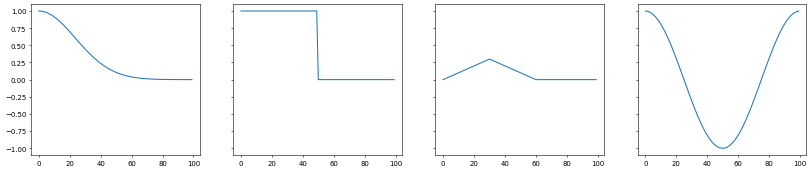

In [3]:
def g(n,x):
    if n==0:
        return math.e**(-9*x**2)
    elif n==1:
        return int(x<0.5)
    elif n==2:
        if x<0.3:
            return x
        elif x<0.6:
            return 0.6-x
        else:
            return 0
    elif n==3:
        return math.cos(2*math.pi*x)
    elif n==4:
        return math.e**(-30*(x-0.5)**2)
    else:
        return np.inf
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(5*ne,4), dpi=50)
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])


### Generate the dataset

If replace==0, without replacement everywhere. Must $n_x*n_t <= n_1*n_2$ and $n_t <= n_2$.  
If replace==1, X[i,:] have different nuisances, but each block in D can appear multiple times in X.  
If replace==2, with replacement everywhere.

In [4]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=1)
MRA_training.generate_default()
X = MRA_training.X

### Print the structure of dataset X

Numbers of each state in X:
0    28
1    28
2    22
3    22
dtype: int64


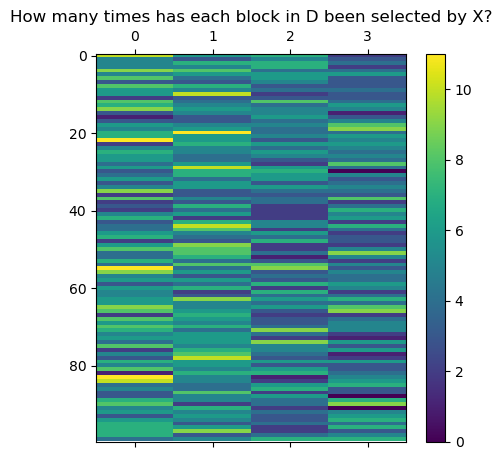

In [5]:
print("Numbers of each state in X:")
print(pd.DataFrame(MRA_training.states).value_counts())
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

### Initialize SymAE and load weights

In [6]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
model.load_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
#model.load_weights('./checkpoint/'+'June21')
clear_output()

### Select the optimizer

In [7]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)

### Train the NeuralNet

In [8]:
M = 50 # How many epochs
epochs = range(M)
losses = [0.0]*M
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait = True)
        losses[epoch] = logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
history = model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 49, loss is 0.025878.


### Plot loss-epoch graph

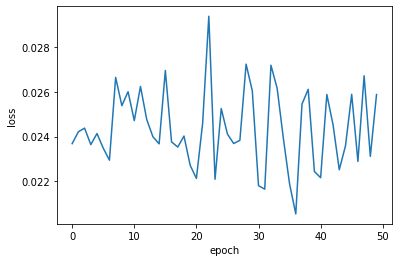

In [9]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Save weights

In [10]:
model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
#model.save_weights('./pq_checkpoint/'+'p=10,q=20')
print("weights saved")

weights saved


# Plot the performance on training set

### Plot the performance on a specific state

1/1 [==============================] - 1s 689ms/step


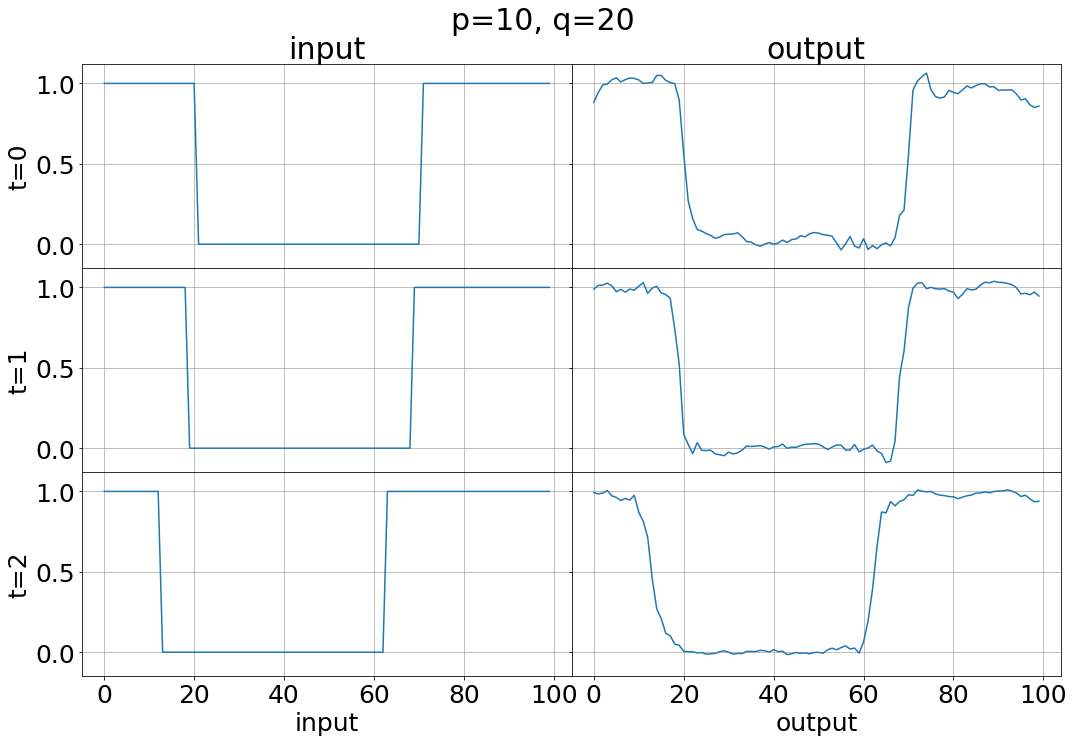

In [12]:
def find_state(state):
    '''
    Generate a dataset with N=1 and this specific state

    Parameters
    ----------
    state : int
        The state you want
        
    Returns
    ----------
    MRA_data : class MRA_generate
    '''
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(100):
        MRA_data.generate_default()
        if MRA_data.states[0]==state:
            return MRA_data
test_X = find_state(1).X
fig = plot_training(model,test_X)

### Save plot

In [13]:
plot_save(fig,ID=-1)

Saved as plot_26.png


# Redatuming

### Choose which 2 states you want to redatum 

In [14]:
MRA1 = find_state(0)
MRA2 = find_state(1)

### Redatuming

The MSE of C1N2 is: 0.187076
The MSE of C2N1 is: 0.465136


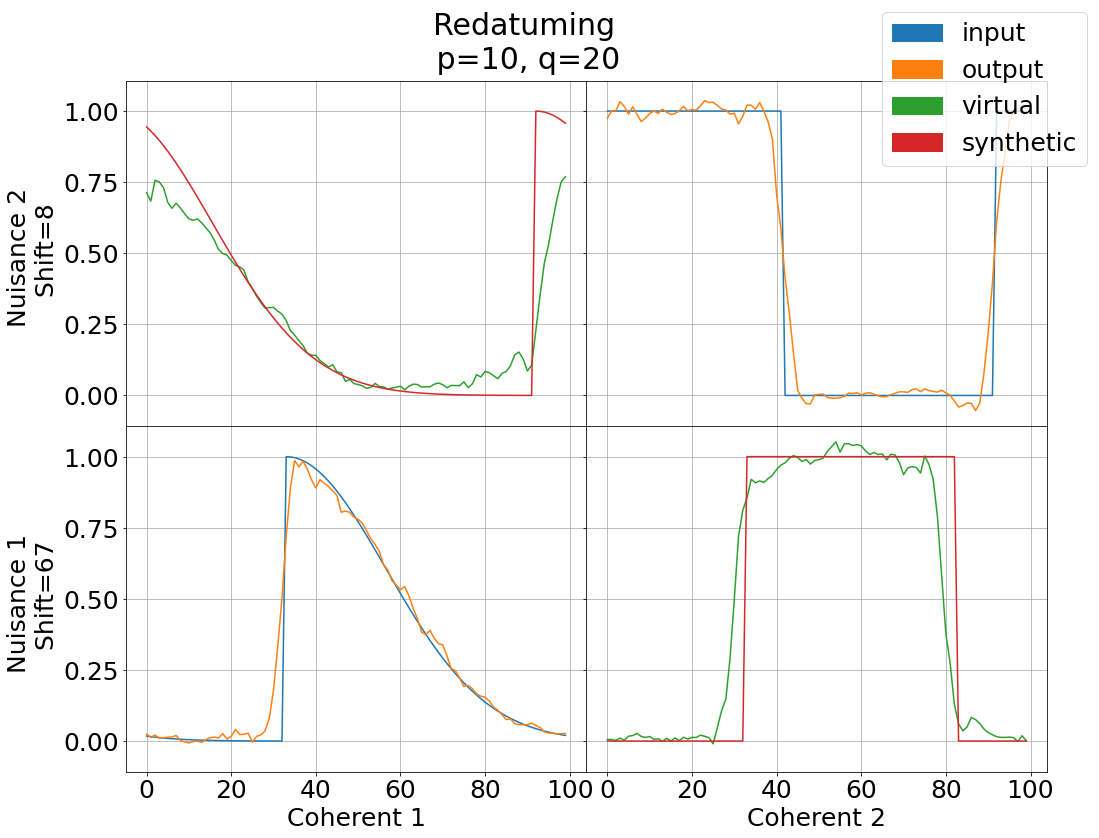

In [15]:
redatum = redatuming(model,MRA1,MRA2,0)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)

### Save redatuming plot

In [ ]:
plot_save(fig,ID=-1)

# 2d-PCA of latent space

### Initialize PCA data

In [17]:
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs, Ns = latent(model,MRA_pca)
pca = PCA(n_components=2)

### Plot PCA of p-space

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 371.65it/s]


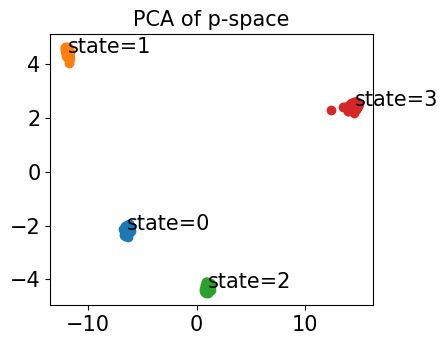

In [18]:
pca_C = pca.fit_transform(Cs)
center = np.empty((ne,2))
fig = plt.figure(figsize=(5,4),dpi=100)
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_pca.states==i,:])/sum(MRA_pca.states==i)
    plt.text(center[i,0],center[i,1],"state=%d"%i,fontsize=15)
for i in trange(1000):
    plt.scatter(pca_C[i,0],pca_C[i,1],color='C%d'%(MRA_pca.states[i]))
plt.title('PCA of p-space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()

### Plot PCA of q-space, only use one state

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 267.65it/s]


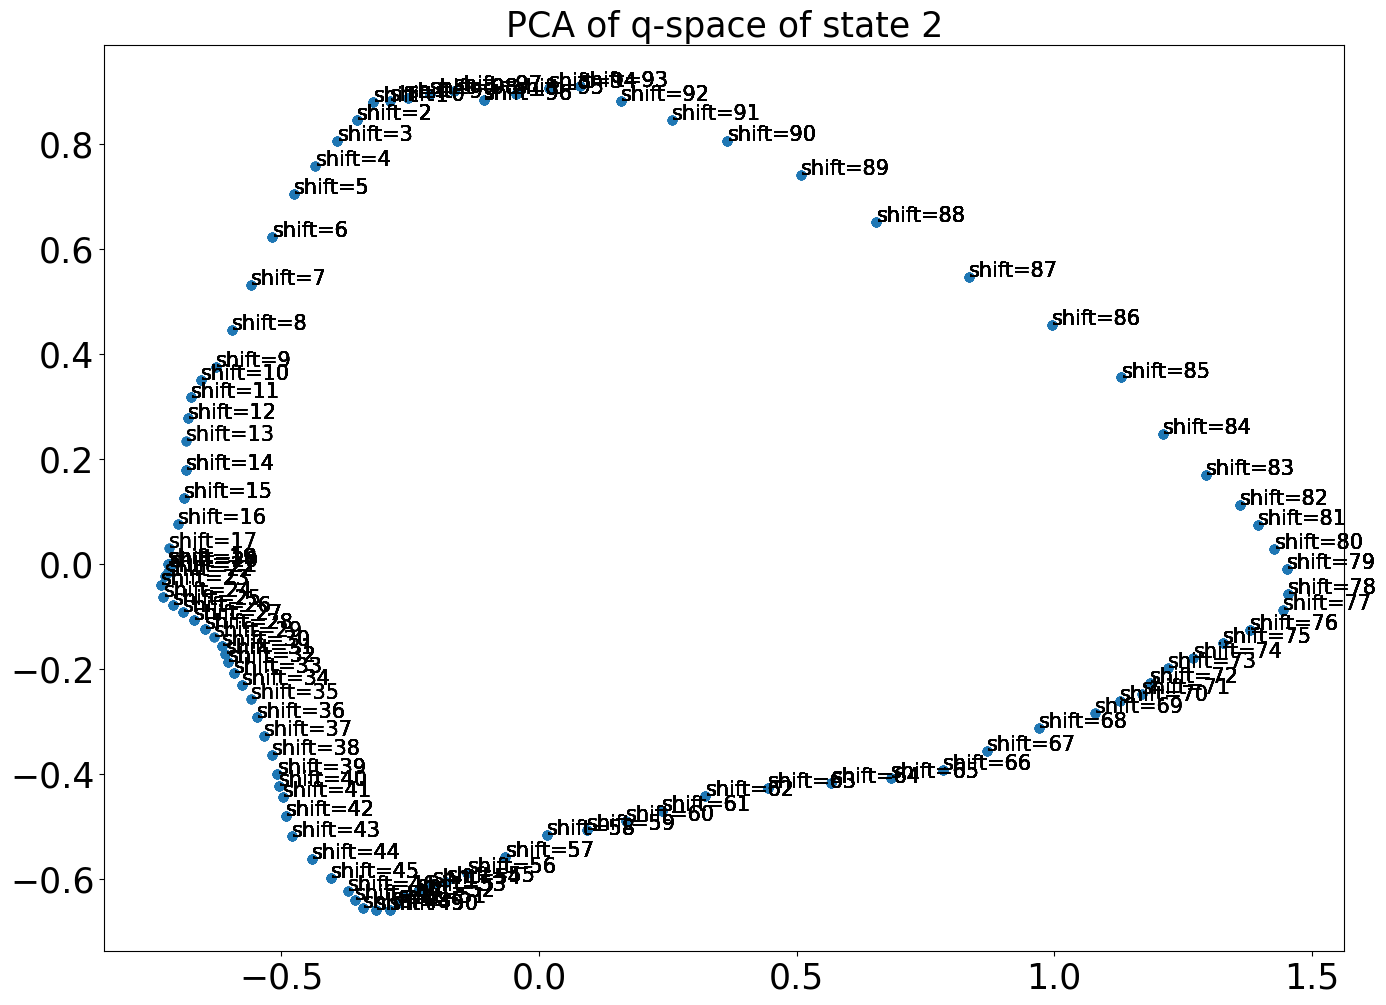

In [19]:
state = 2
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q)
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:]
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
fig = plt.figure(figsize=(16,12),dpi=100)
for i in trange(1000):
    plt.scatter(pca_N[i,0],pca_N[i,1],color='C0')
    plt.text(pca_N[i,0],pca_N[i,1],"shift=%d"%N_shifts[i//nt,i%nt],fontsize=15)
plt.title('PCA of q-space of state %d'%state,fontsize=25)
plt.tick_params(labelsize=25)

### PCA of q-space uisng all states

100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 251.00it/s]


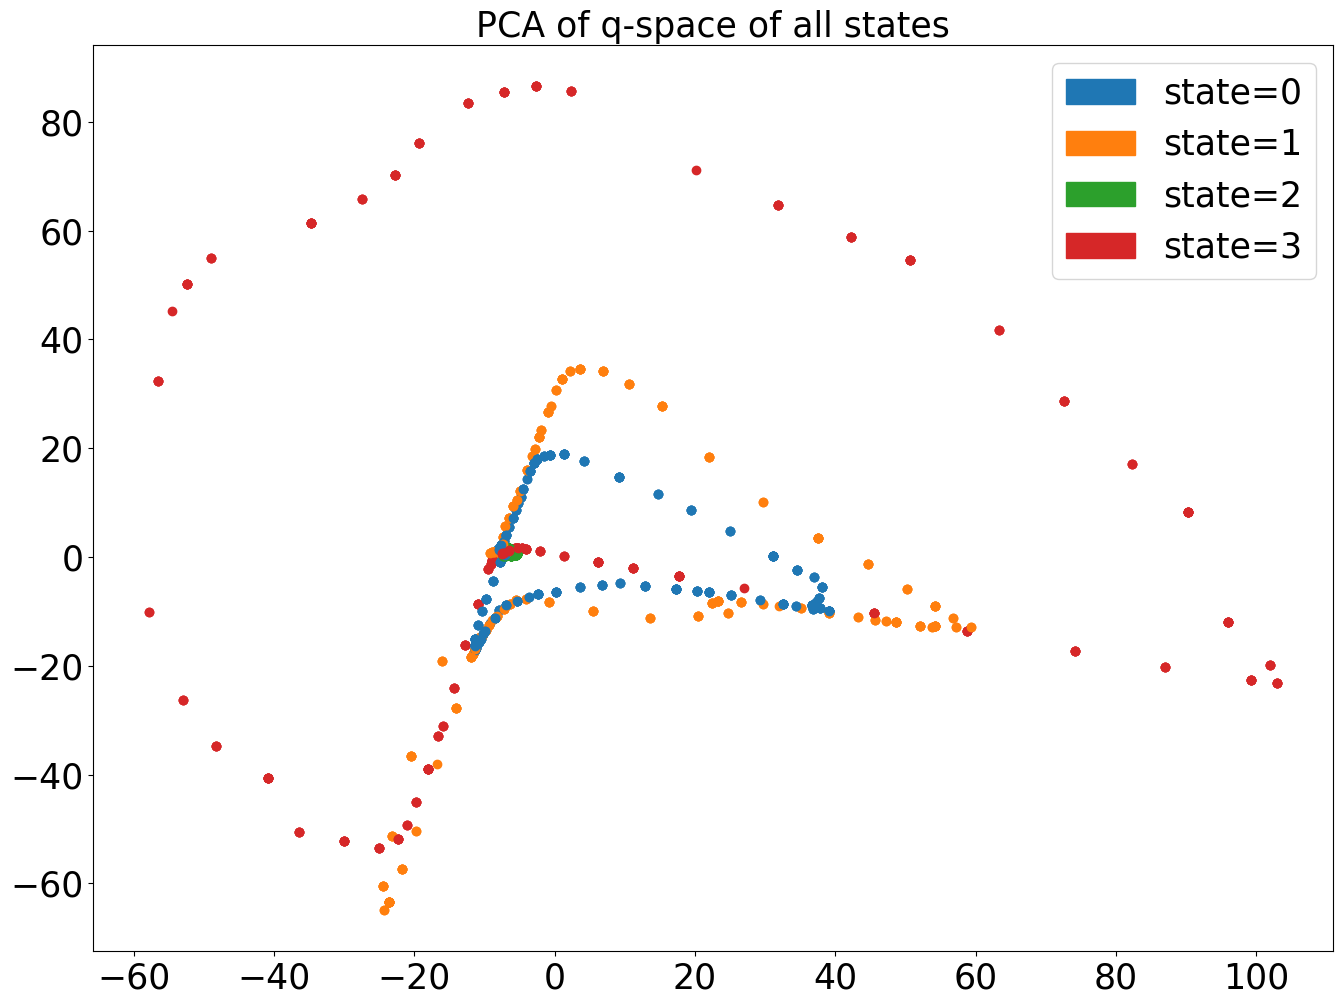

In [20]:
N_reshaped = Ns.reshape(-1,q)
pca = PCA(n_components=2)
pca.fit(N_reshaped)
pca_N = pca.transform(N_reshaped)
fig = plt.figure(figsize=(16,12),dpi=100)
for i in trange(2000):
    plt.scatter(pca_N[i,0],pca_N[i,1],color='C%d'%(MRA_pca.states[i//nt]))
    #plt.text(pca_N[i,0],pca_N[i,1],"%d"%MRA.shifts[i//nt,i%nt],fontsize=15,fontweight='ultralight')
plt.title('PCA of q-space of all states',fontsize=25)
plt.tick_params(labelsize=25)
blue_patch = mpatches.Patch(color='C0', label='state=0')
orange_patch = mpatches.Patch(color='C1', label='state=1')
green_patch = mpatches.Patch(color='C2', label='state=2')
red_patch = mpatches.Patch(color='C3', label='state=3')
plt.legend(handles=[blue_patch,orange_patch,green_patch,red_patch])
#plt.tight_layout()
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.show()

### PCA of p+q space

In [ ]:
Cs_Ns_merger = model.distzsym(np.concatenate([Cs, Ns], axis=1))
Cs_Ns_merger = np.array(Cs_Ns_merger).reshape(-1,p+q)
pca_Cs_Ns_merger = pca.fit_transform(Cs_Ns_merger)
fig = plt.figure(figsize=(5,4),dpi=100)
for i in trange(1000):
    plt.scatter(pca_Cs_Ns_merger[i,0],pca_Cs_Ns_merger[i,1],color='C%d'%(MRA_pca.states[i//nt]))
plt.title('PCA of p+q space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()

# 3d-PCA of latent space

### Initialize MRA and PCA

In [22]:
pca = PCA(n_components=3)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)

### PCA of p-space

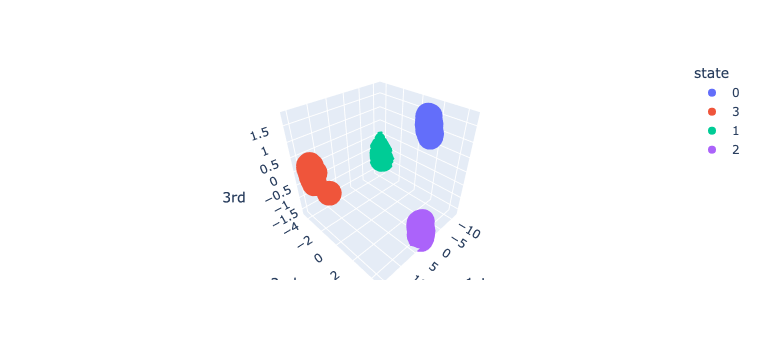

In [23]:
pca.fit(Cs)
pca_C = pca.fit_transform(Cs)
df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(MRA_pca.states,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

### PCA of q-space of one specific state

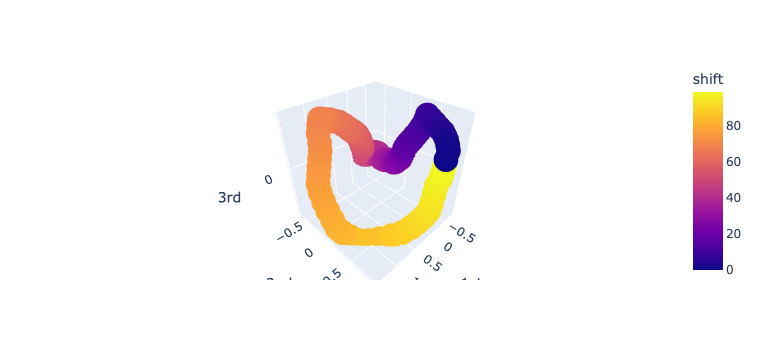

In [24]:
state = 2
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q) 
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:].reshape(-1,1)
pca = PCA(n_components=3)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='shift')
fig.show()

### PCA in q-space of all states

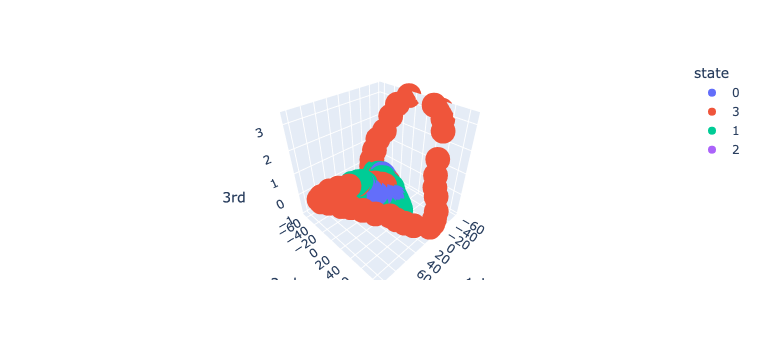

In [25]:
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,df_states,df_shifts],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

# How dec(c,n) depends on c and n?

### Embed MRA distance into latent space

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:,0]
def d_latent(latent_code_1, latent_code_2):
    signal_1 = dec(latent_code_1)
    signal_2 = dec(latent_code_2)
    return rho(signal_1, signal_2)

### Initialize data

In [ ]:
MRA_embed = MRA_generate(d,nt,1000,sigma,ne,g,replace=False,outer_replace=True)
MRA_embed.generate_default()
Cs, Ns = latent(model,MRA_embed)
Ns = Ns.reshape(-1, q)
coherent_pca = PCA(n_components=2)
coherent_pca.fit(Cs)
nuisance_pca = PCA(n_components=2)
nuisance_pca.fit(Ns)
Ns = Ns.reshape(-1, nt, q)

### p-space centers

In [ ]:
pca_C = coherent_pca.fit_transform(Cs)
center = np.empty((ne,2))
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_embed.states==i,:])/sum(MRA_embed.states==i)

### Fix c, move n

In [ ]:
state = 0
x_ticks = range(-60,60,4)
y_ticks = range(-60,60,4)
pca_coherent_code = center[state,:]
pca_N = nuisance_pca.fit_transform(Ns[MRA_embed.states==state,:].reshape(-1,q))
coherent_code = coherent_pca.inverse_transform(pca_coherent_code)
fig, axs = plt.subplots(len(x_ticks), len(y_ticks), sharex=True, sharey=True, figsize=(len(x_ticks),len(y_ticks)), dpi=50)
fig.suptitle('latent coherent code=(%f,%f)'%(pca_coherent_code[0],pca_coherent_code[1]))
for i in tqdm(range(len(y_ticks))):
    for j in range(len(x_ticks)):
        a = x_ticks[j]
        b = y_ticks[-1-i]
        nuisance_code = nuisance_pca.inverse_transform([a,b])
        axs[i,j].plot(range(d), dec(np.concatenate((coherent_code, nuisance_code), axis=0)))
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])   
        if i == len(y_ticks)-1:
            axs[i,j].set_xlabel('%d'%a)
        if j == 0:
            axs[i,j].set_ylabel('%d'%b)
        if np.min(np.sum((pca_N-[a,b])**2, axis=1)) < 5:
            axs[i,j].patch.set_facecolor("lightyellow")
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
plot_save(fig, ID=-1)

### Fix n, move c

In [ ]:
state = 1
pca_N = nuisance_pca.fit_transform(Ns[MRA_embed.states==state,:].reshape(-1,q))
x_ticks=range(-50,50,4)
y_ticks=range(-50,50,4)
fig, axs = plt.subplots(len(x_ticks), len(y_ticks), sharex=True, sharey=True, figsize=(len(x_ticks),len(y_ticks)), dpi=50)
fig.suptitle('latent coherent code=(%f,%f)'%(center[state,0],center[state,1]))
for i in tqdm(range(len(y_ticks))):
    for j in range(len(x_ticks)):
        a = x_ticks[j]
        b = y_ticks[-1-i]
        nuisance_code = nuisance_pca.inverse_transform([a,b])
        axs[i,j].plot(range(d), dec(np.concatenate((coherent_code, nuisance_code), axis=0)))
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])   
        if i == len(y_ticks)-1:
            axs[i,j].set_xlabel('%d'%a)
        if j == 0:
            axs[i,j].set_ylabel('%d'%b)
        if np.min(np.sum((pca_N-[a,b])**2, axis=1)) < 5:
            axs[i,j].patch.set_facecolor("lightyellow")
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plot_save(fig, ID=0)

# Others

### Latent nuisance code vs. latent coherence code

In [ ]:
which_dim_in_q=0
fig=plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel('coherent code',fontsize=20)
plt.ylabel('%d-th nuisance code'%which_dim_in_q,fontsize=20)
plt.title('latent space',fontdict = {'fontsize' : 25})
for s in list(range(ne))*5:
    MRA=find_state(s)
    C,N=latent(model,MRA)
    for i in range(nt//5):
        plt.scatter(C[0],N[q*i+which_dim_in_q])
        plt.text(C[0],N[q*i+which_dim_in_q],"s=%d,l=%d"%(MRA.states[0],MRA.shifts[0,i]),fontsize=15)
#plt.xlim([-10,8])
#plt.ylim([-1,1])
clear_output()
plt.tight_layout()

### Save plot

In [ ]:
plot_save(fig,ID=-1)

### Latent nuisance code vs. shift

In [ ]:
s=0
which_dim_in_q=2
fig=plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel('shift',fontsize=20)
plt.ylabel('%d-th nuisance code'%which_dim_in_q,fontsize=20)
plt.title('latent space',fontdict = {'fontsize' : 25})
for ii in range(10):
    MRA=find_state(s)
    C,N=latent(model,MRA)
    shifts=MRA.shifts
    for i in range(nt):
        plt.scatter(shifts[0][i],N[0][i*q+which_dim_in_q])
#plt.xlim([-10,8])
#plt.ylim([-1,1])
clear_output()
plt.tight_layout()

### Save plot

In [ ]:
plot_save(fig,ID=-1)